In [23]:
import bolid_vision

In [2]:
TRAINING_DATASET_PATH = 'C:\\PRZEMEK\\Data_Analysis\\projects\\Python\\F1\\BolidVision\\data\\raw\\red_bull_mercedes_jpg'
TEST_DATASET_PATH = 'C:\\PRZEMEK\\Data_Analysis\\projects\\Python\\F1\\BolidVision\\data\\test_dataset'

In [4]:
train_dataset, validation_dataset, test_dataset = bolid_vision.create_datasets(
    TRAINING_DATASET_PATH, TEST_DATASET_PATH)

Found 109 files belonging to 2 classes.
Using 88 files for training.
Found 109 files belonging to 2 classes.
Using 21 files for validation.
Found 22 files belonging to 2 classes.
Classes: ['mercedes', 'red_bull']


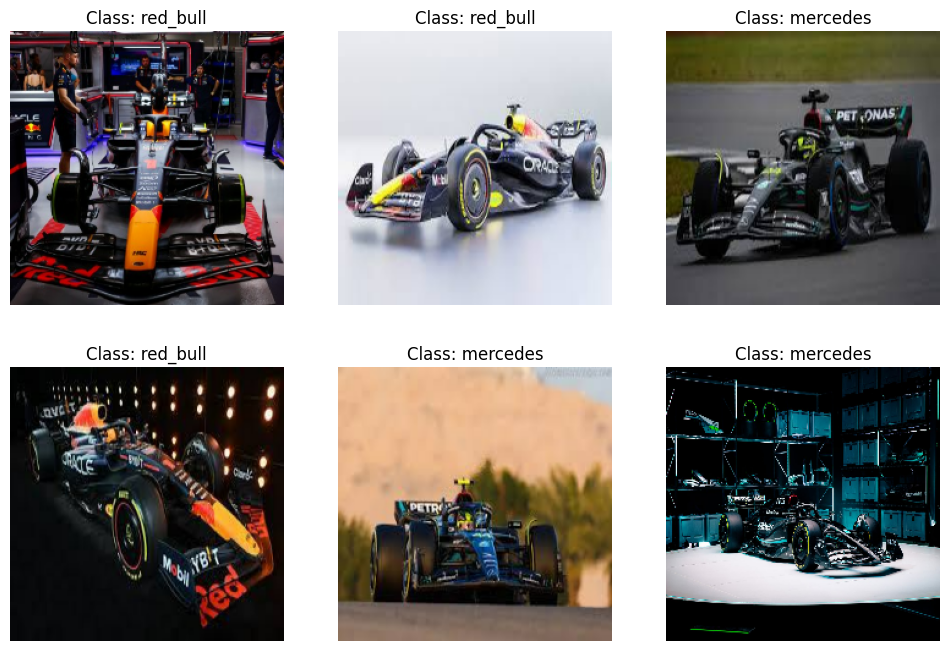

In [5]:
bolid_vision.display_images_from_dataset(train_dataset)

In [6]:
model, history = bolid_vision.create_and_train_vgg19_model(train_dataset, validation_dataset)

Epoch 1/20
3/3 [==============================] - 19s 6s/step - loss: 17.6344 - accuracy: 0.5000 - val_loss: 9.6104 - val_accuracy: 0.5238 - lr: 0.0010
Epoch 2/20
3/3 [==============================] - 17s 6s/step - loss: 19.5180 - accuracy: 0.5227 - val_loss: 9.6913 - val_accuracy: 0.5238 - lr: 0.0010
Epoch 3/20
3/3 [==============================] - 17s 6s/step - loss: 6.3628 - accuracy: 0.5568 - val_loss: 8.6381 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 4/20
3/3 [==============================] - 17s 6s/step - loss: 3.0920 - accuracy: 0.6818 - val_loss: 7.5875 - val_accuracy: 0.5238 - lr: 0.0010
Epoch 5/20
3/3 [==============================] - 17s 6s/step - loss: 5.0754 - accuracy: 0.5682 - val_loss: 1.0132 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 6/20
3/3 [==============================] - 17s 6s/step - loss: 2.9868 - accuracy: 0.6705 - val_loss: 0.8300 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 7/20
3/3 [==============================] - 17s 6s/step - loss: 0.9026 - accuracy: 0.7

In [7]:
model.save('C:\\PRZEMEK\\Data_Analysis\\projects\\Python\\F1\\BolidVision\\models\\model_2.keras')

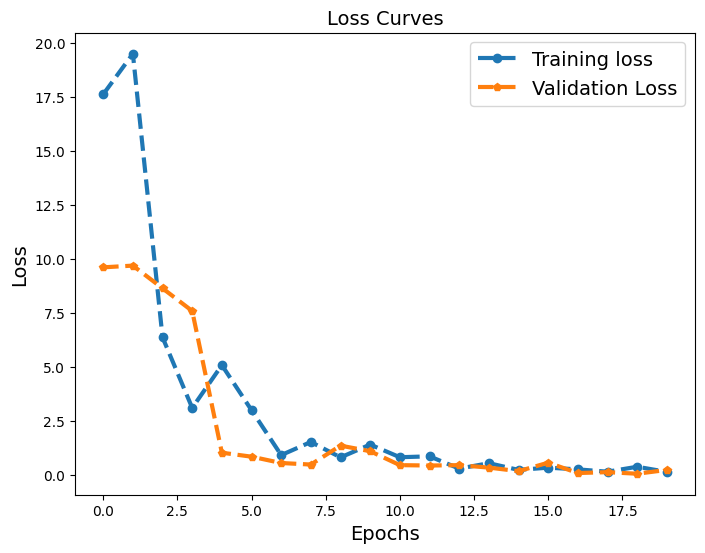

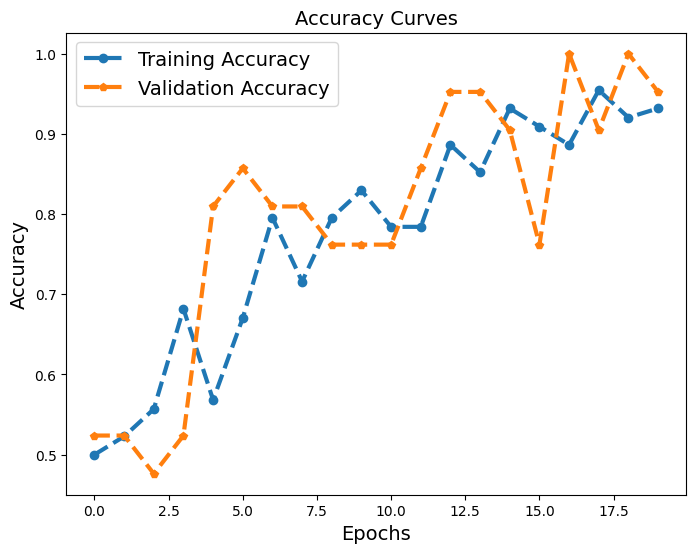

In [8]:
bolid_vision.plot_history(history)

In [9]:
true_labels, predictions = bolid_vision.get_predictions(model, test_dataset)

1/1 [==============================] - 3s 3s/step


In [11]:
report = bolid_vision.classification_report(true_labels, predictions)
print(report)

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        11
         1.0       0.92      1.00      0.96        11

    accuracy                           0.95        22
   macro avg       0.96      0.95      0.95        22
weighted avg       0.96      0.95      0.95        22



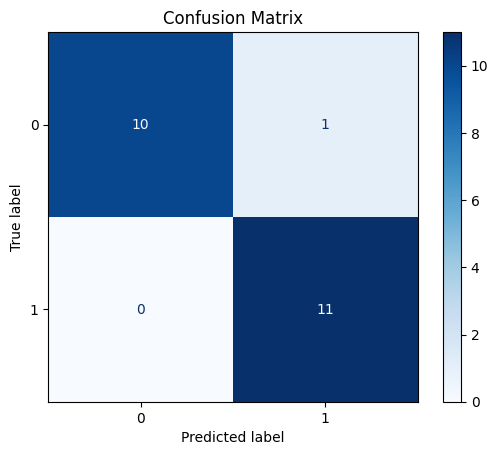

In [12]:
bolid_vision.plot_confusion_matrix(true_labels, predictions)

In [14]:
image_url ='https://bi.im-g.pl/im/34/e0/18/z26084404AMP,Nowy-bolid-Mercedesa-na-sezon-2020-w-Formule-1--Zr.jpg'

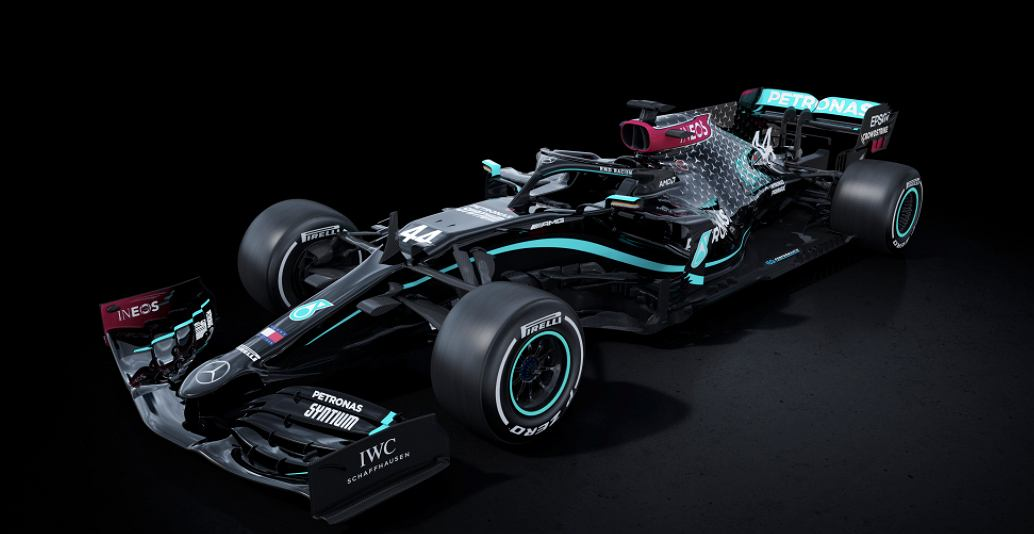

1/1 [==============================] - 0s 151ms/step
An error occurred: index 1 is out of bounds for axis 0 with size 1


In [18]:
bolid_vision.display_and_predict_img(image_url, model, train_dataset)

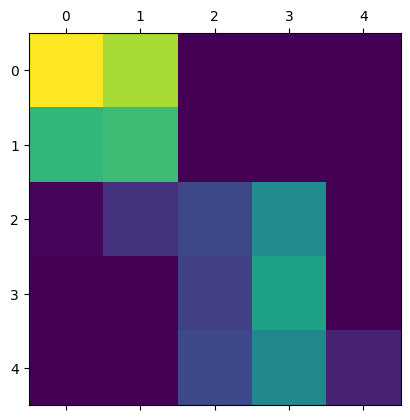

In [44]:
heatmap = bolid_vision.generate_and_display_heatmap(img_path, model, 'conv2d')

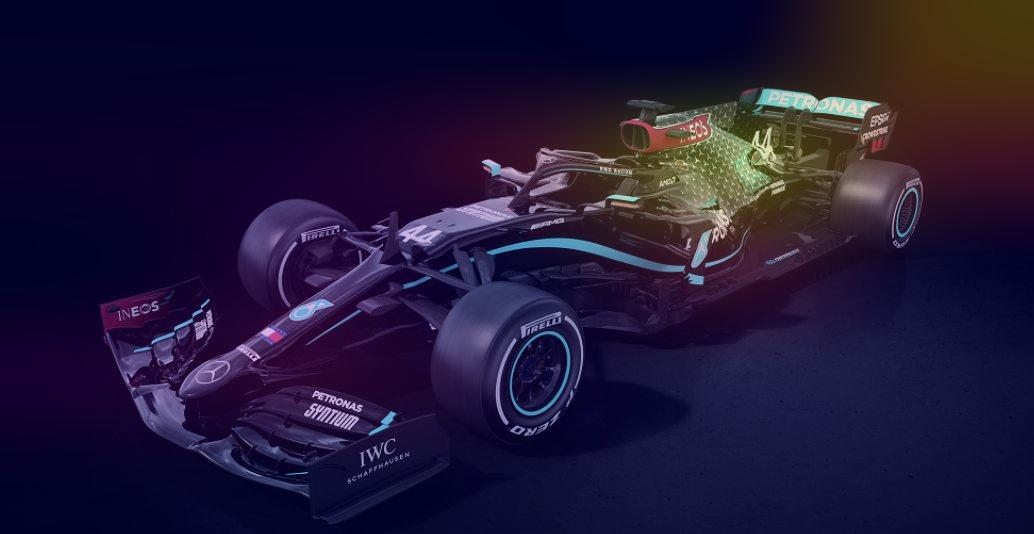

In [45]:
bolid_vision.save_and_display_gradcam(img_path, model, heatmap, 'conv2d')

In [46]:
import matplotlib.pyplot as plt

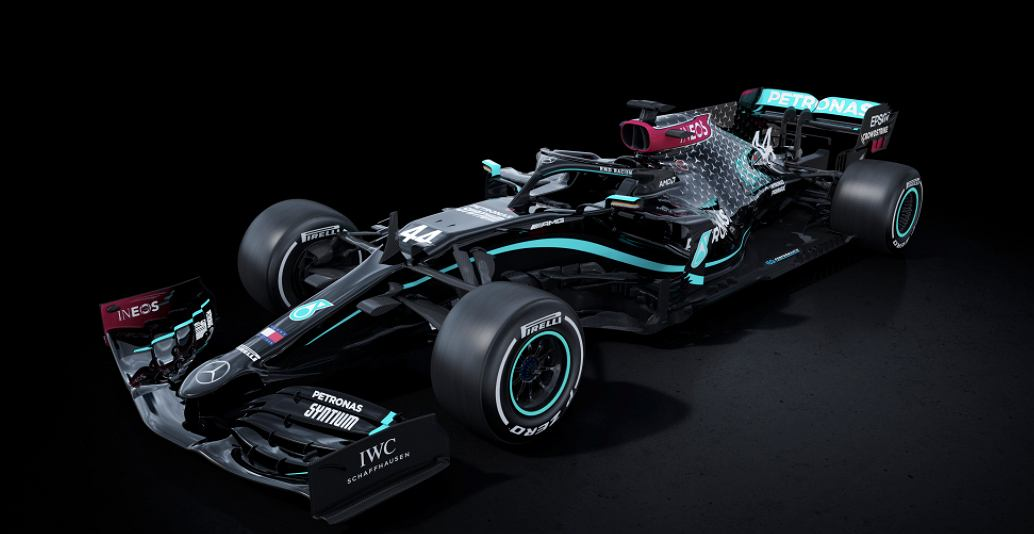

In [38]:
img_path = bolid_vision.display_and_save_img(image_url)

In [29]:
explanation = bolid_vision.explain_image(img_path, model)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


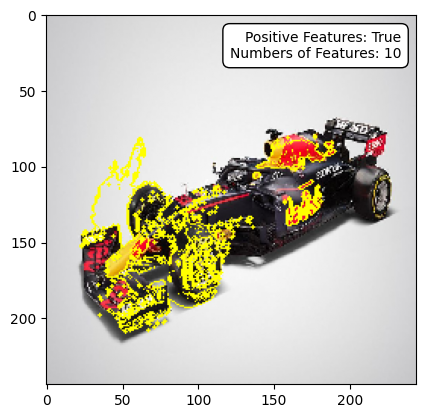

In [32]:
bolid_vision.visualize_explanation(explanation)

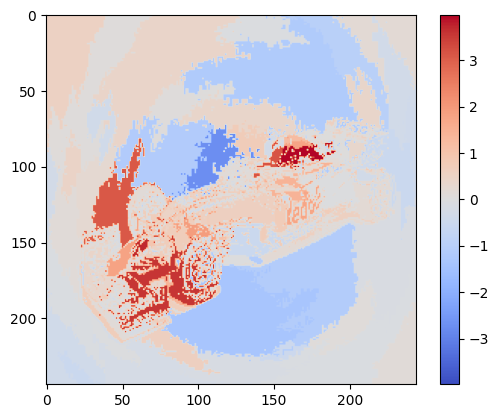

In [40]:
bolid_vision.visualize_explanation_heatmap(explanation)